In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ruptures as rpt
sns.set_style('darkgrid')
from fertilizantes_utils import *
import locale
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf #, plot_ccf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Establecer el idioma español para fechas en Windows
locale.setlocale(locale.LC_TIME, 'Spanish_Spain.1252')

'Spanish_Spain.1252'

In [2]:
df = pd.read_excel('data/predicción_precios_fertilizantes.xlsx', index_col='date')

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 154 entries, 2011-11-30 to 2024-08-31
Data columns (total 11 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   fob_urea_kg                              150 non-null    float64
 1   crude_oil_brent_usd_per_bbl              154 non-null    float64
 2   natural_gas_europe_usd_per_mmbtu         154 non-null    float64
 3   inflación_mensual                        154 non-null    float64
 4   ipc_diesel                               140 non-null    float64
 5   precipitación_media_mm                   146 non-null    float64
 6   temp_media_Celsius                       146 non-null    float64
 7   fob_otros_prod_agrícolas_exportados_usd  140 non-null    float64
 8   fosfato diamónico 18-46-0                140 non-null    float64
 9   muriato de potasio 0-0-60                140 non-null    float64
 10  urea 46-0-0                    

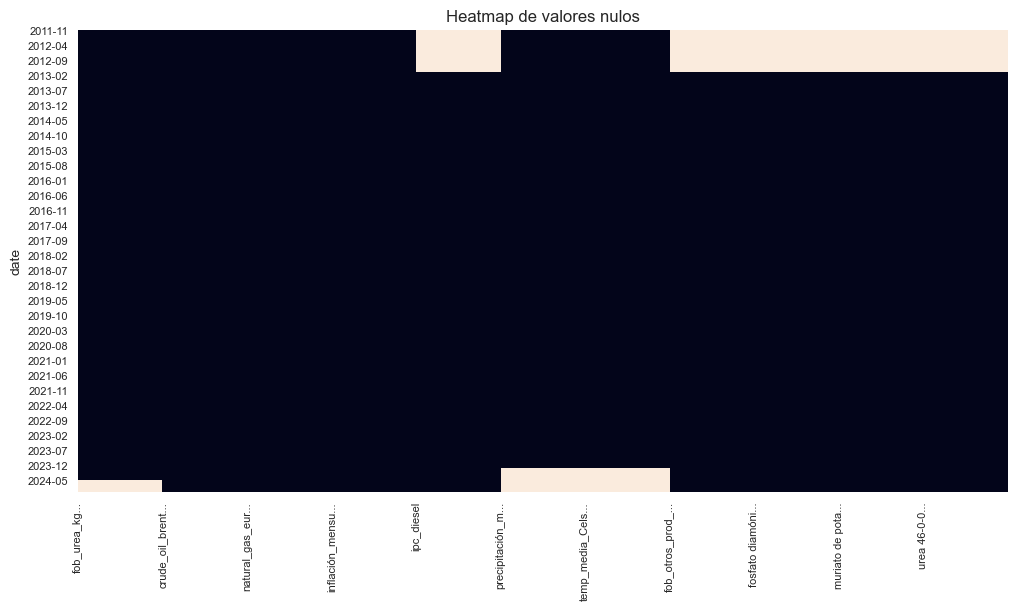

In [3]:
df_na = df.copy()

df_na.index = df_na.index.strftime('%Y-%m')

truncated_labels = [col[:15] + "..." if len(col) > 10 else col for col in df.columns]

plt.figure(figsize=(12, 6))
sns.heatmap(df_na.isna(), cbar=False)
plt.title("Heatmap de valores nulos")
plt.xticks(ticks=range(len(df.columns)), labels=truncated_labels, size=8)
plt.yticks(size=8)
# plt.tight_layout()
plt.show()

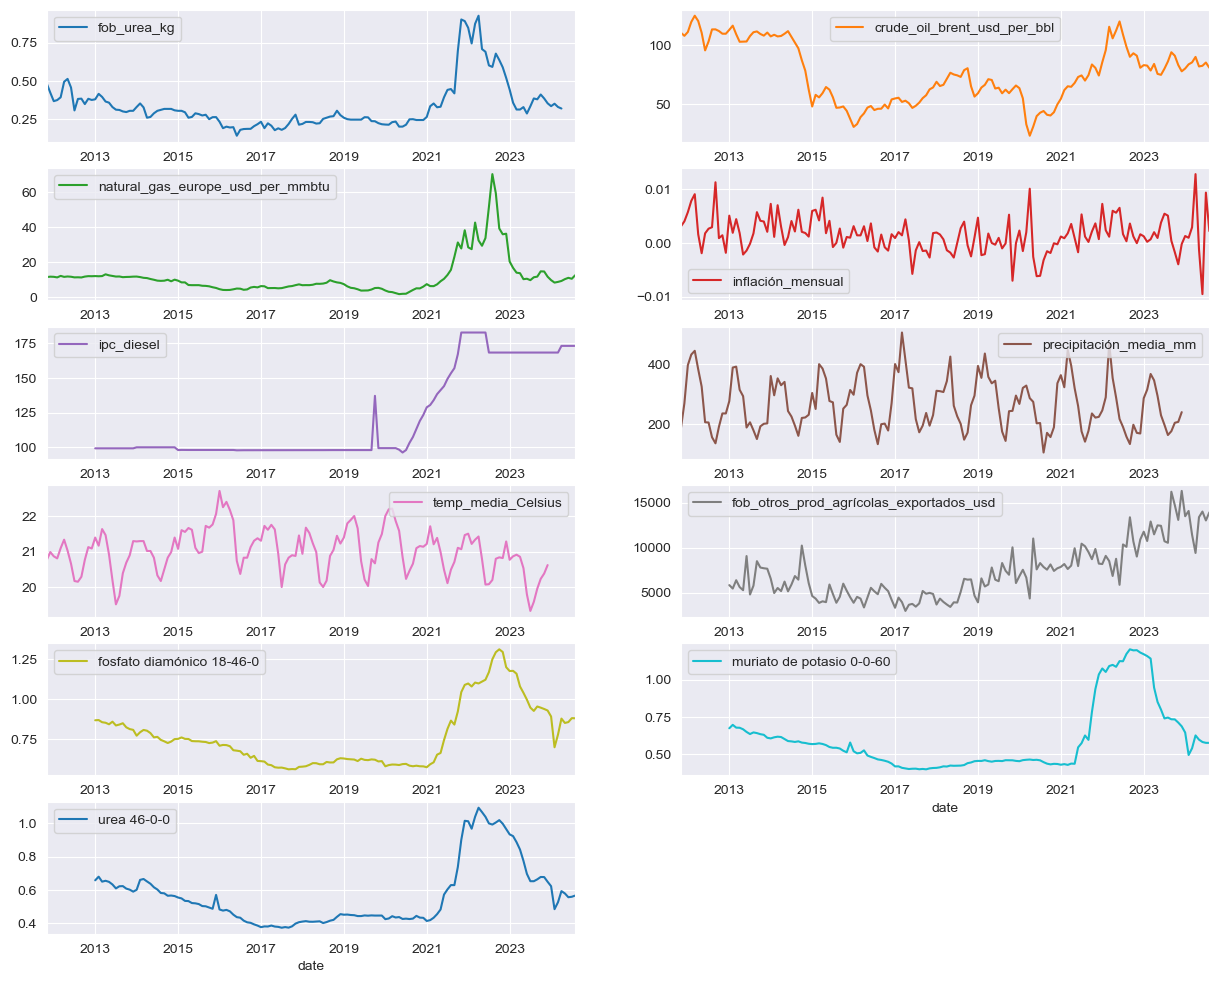

In [4]:
num_de_filas = ((df.shape[1] + 1) // 2)

df.plot(
    subplots=True,
    layout=(num_de_filas, 2), # filas, columnas
    figsize=(15, 2 * num_de_filas),
    sharex=False
    )
plt.show()

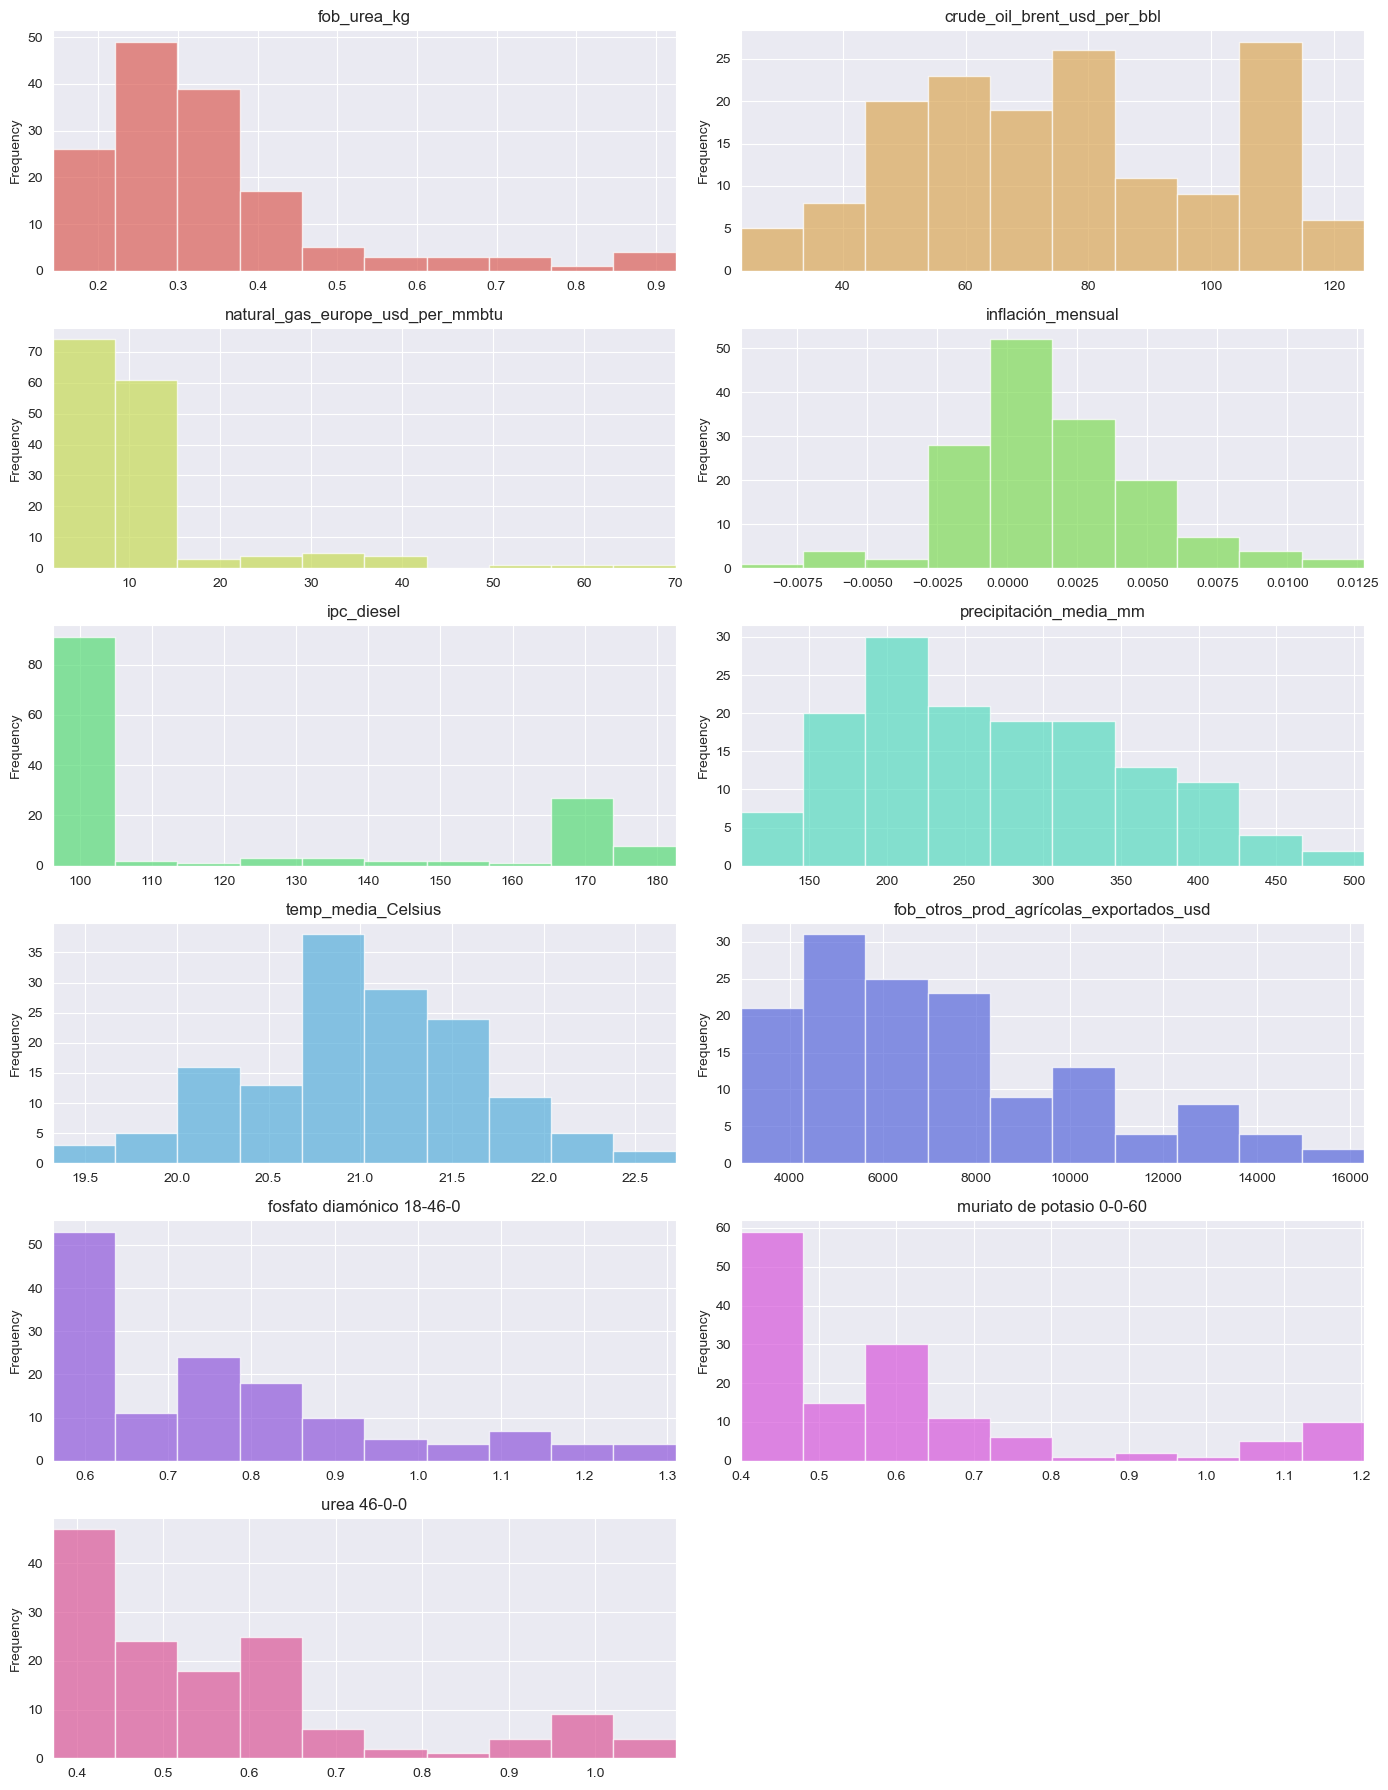

In [5]:
plot_histograms(df, n_rows=num_de_filas, bins=10, color_palette='hls')

### Cointegración

In [6]:
df_sin_na = df.dropna()

lista_fertilizantes = ['fosfato diamónico 18-46-0', 'muriato de potasio 0-0-60', 'urea 46-0-0']

# Extraer variables predictoras:
X = df_sin_na.drop(columns=lista_fertilizantes)

# Extraer variable objetivo:
target_var = 'urea 46-0-0'
y = df_sin_na[target_var]

In [7]:
# Evaluar estacionareidad de cada variable por ADF y KPSS:
evaluar_estacionareidad_vars = evaluar_estacionareidad(df_sin_na)

# Obtener lista de variables no estacionarias:
variables_no_estacionarias = evaluar_estacionareidad_vars.query("estado_estacionario != 'Estacionario'")['variable'].tolist()

# Crear dataframe solamente con variables no estacionarias:
df_no_estacionarias = df_sin_na[variables_no_estacionarias]

# Crear dataframe de variables exógenas al modelo de cointegración (en este caso, las variables estacionarias):
set_vars_exógenas = set(df_sin_na.columns) - set(variables_no_estacionarias)
df_exógenas = df_sin_na[list(set_vars_exógenas)]

# Eliminar las variables fertilizantes que no son de interés: 
columns_to_drop = [col for col in lista_fertilizantes if col != target_var]
df_test_cointegración = df_no_estacionarias.drop(columns=columns_to_drop)

El **Vector AutoRegresivo** (VAR) es un modelo econométrico que captura las relaciones dinámicas entre varias series temporales tratándolas como variables endógenas. A diferencia de modelos univariados, el VAR permite que cada variable dependa de sus propios rezagos y de los rezagos de las demás, sin suponer relaciones causales específicas. Esto lo hace útil para analizar cómo los cambios en una variable afectan a las demás a lo largo del tiempo. Es ideal para identificar patrones de interdependencia y realizar análisis de impacto como impulso-respuesta o descomposición de varianza.

In [8]:
from statsmodels.tsa.api import VAR

# Ajusta un modelo VAR preliminar
modelo_var = VAR(df_test_cointegración, freq='M')
orden_rezagos = modelo_var.select_order(maxlags=12)
print(orden_rezagos.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        28.00       28.19   1.447e+12       28.08
1        16.17      17.84*   1.054e+07       16.85
2        15.40       18.56   4.940e+06      16.68*
3        15.67       20.32   6.725e+06       17.56
4        15.53       21.67   6.265e+06       18.02
5        15.43       23.04   6.288e+06       18.52
6        15.12       24.23   5.539e+06       18.82
7        14.60       25.19   4.241e+06       18.90
8        14.20       26.28   4.131e+06       19.10
9        13.78       27.35   4.630e+06       19.29
10       13.10       28.15   4.951e+06       19.21
11       11.88       28.42   4.340e+06       18.60
12      9.385*       27.41  1.807e+06*       16.71
--------------------------------------------------


**Hannan-Quinn Information Criterion** (HQIC) es un método para seleccionar el mejor modelo estadístico equilibrando precisión y simplicidad. Similar al AIC y BIC, penaliza la complejidad del modelo de forma más moderada que BIC y más estrictamente que AIC. Su fórmula incluye un término que depende del logaritmo doble del tamaño de la muestra, lo que lo hace ideal para modelos con datos de tamaño moderado. En el contexto del VAR, el HQIC es útil para elegir el número óptimo de rezagos, evitando sobreajuste al capturar las dinámicas principales entre las variables.

In [117]:
# Obtener el valor de lags óptimo según HQIC:
maxlags_óptimo = 6 # orden_rezagos.selected_orders['hqic']

print("Número de lags óptimo según HQIC: ", maxlags_óptimo)

Número de lags óptimo según HQIC:  6


La **prueba de Johansen** es un método econométrico utilizado para identificar relaciones de equilibrio a largo plazo (cointegración) entre múltiples series temporales no estacionarias. A diferencia de otros enfoques, como *Engle-Granger*, permite analizar más de dos variables simultáneamente. La prueba utiliza un modelo VAR para evaluar si existe una combinación lineal estacionaria entre las series. Sus resultados indican cuántos vectores de cointegración existen, lo que ayuda a decidir si las variables tienen una relación estable a largo plazo y si se debe utilizar un modelo como el VECM para capturar dichas dinámicas.

In [118]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

cointegración_johansen = coint_johansen(df_test_cointegración, det_order=0, k_ar_diff=maxlags_óptimo)

estadísticos_de_traza = cointegración_johansen.lr1
valores_críticos = cointegración_johansen.cvt

print("Estadísticos de traza:\n", estadísticos_de_traza)
print("Valores críticos:\n[1% | 5% | 10%]\n", valores_críticos)

Estadísticos de traza:
 [310.01272734 199.95399585 132.14323901  82.50740141  46.86135864
  25.29837886  11.68249363   2.80733849]
Valores críticos:
[1% | 5% | 10%]
 [[153.6341 159.529  171.0905]
 [120.3673 125.6185 135.9825]
 [ 91.109   95.7542 104.9637]
 [ 65.8202  69.8189  77.8202]
 [ 44.4929  47.8545  54.6815]
 [ 27.0669  29.7961  35.4628]
 [ 13.4294  15.4943  19.9349]
 [  2.7055   3.8415   6.6349]]


In [119]:
# Extraer columna del 5% de nivel de confianza:
valores_críticos_5_pct = valores_críticos[:, 1]  

# Establecer vectores de cointegración base r=0:
r = 0

# Determinar r automáticamente:
for i, (trace, critical) in enumerate(zip(estadísticos_de_traza, valores_críticos_5_pct)):
    if trace > critical:
        # Incrementar r si se rechaza la hipótesis nula:
        r = i + 1

print(f"Número de vectores de cointegración (r): {r}")

Número de vectores de cointegración (r): 4


Los resultados de la prueba de Johansen ayudan a determinar el número de relaciones de equilibrio a largo plazo (vectores de cointegración) entre las variables no estacionarias en un sistema. Se evalúan los estadísticos de traza (Trace Statistic), que indican si se puede rechazar la hipótesis nula (*H0*) de que hay *r* vectores de cointegración frente a la alternativa de que hay más de *r*. Cada valor se compara con los valores críticos en distintos niveles de significancia (1%, 5%, 10%). Si el estadístico de traza supera el valor crítico al 5%, se rechaza *H0*​, lo que implica que existe al menos *r+1* vectores de cointegración. El número final de vectores de cointegración es el mayor *r* para el cual no se rechaza *H0*​. Este número define cuántas relaciones lineales estacionarias unen las variables, y se utiliza para ajustar un modelo VECM que combine dinámicas de corto y largo plazo.

- Para r=0 (ningún vector de cointegración), el estadístico de traza es 254.76, mayor que el valor crítico de 159.53, por lo que se rechaza *H0*​. Esto indica que hay al menos un vector de cointegración.
- Para r≤1, el estadístico es 166.18, nuevamente mayor que el valor crítico de 125.62. Se rechaza *H0*​, lo que implica que hay al menos dos vectores de cointegración.
- Para r≤2, el estadístico de traza es 99.20, también superior al valor crítico de 95.75. Se rechaza *H0*​, lo que sugiere que hay al menos tres vectores de cointegración.
- Para r≤3, el estadístico es 61.81, menor que el valor crítico de 69.82, por lo que no se rechaza *H0*​. Esto indica que no hay más de tres vectores de cointegración.

En resumen, los resultados concluyen que existen exactamente tres vectores de cointegración (r=3) entre las variables, lo que significa que estas tienen relaciones de equilibrio a largo plazo que pueden ser modeladas utilizando un modelo VECM con r=3.



In [120]:
from statsmodels.tsa.vector_ar.vecm import VECM

# Ajustar el modelo VECM
modelo_vecm = VECM(
    df_test_cointegración,  # DataFrame con variables no estacionarias
    k_ar_diff=maxlags_óptimo,  # Número de rezagos diferenciales basado en el VAR
    coint_rank=r,  # Número de vectores de cointegración según Johansen
    exog=df_exógenas,
    freq='M'
).fit()

# Resumen del modelo
print(modelo_vecm.summary())

          Det. terms outside the coint. relation & lagged endog. parameters for equation fob_urea_kg          
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
exog1                                          1.5169      1.093      1.387      0.165      -0.626       3.660
L1.fob_urea_kg                                 0.4517      0.094      4.791      0.000       0.267       0.636
L1.crude_oil_brent_usd_per_bbl                 0.0010      0.001      1.646      0.100      -0.000       0.002
L1.natural_gas_europe_usd_per_mmbtu            0.0045      0.001      4.248      0.000       0.002       0.007
L1.ipc_diesel                                  0.0011      0.001      1.704      0.088      -0.000       0.002
L1.precipitación_media_mm                     -0.0002      0.000     -1.883      0.060      -0.000    9.37e-06
L

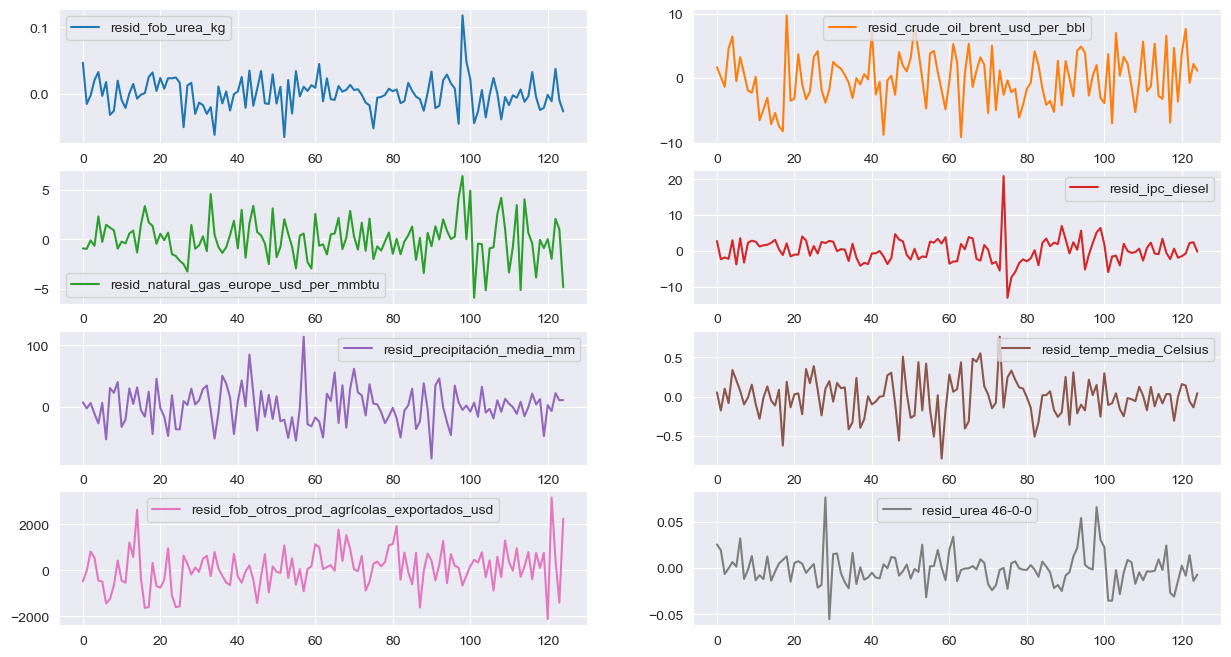

In [121]:
residuos_vecm = pd.DataFrame()

for var_name, resid in zip(df_test_cointegración.columns, modelo_vecm.resid.T):
    residuos_vecm["resid_" + var_name] = resid

num_de_filas = ((residuos_vecm.shape[1] + 1) // 2)

residuos_vecm.plot(
    subplots=True,
    layout=(num_de_filas, 2), # filas, columnas
    figsize=(15, 2 * num_de_filas),
    sharex=False
    )
plt.show()

In [122]:
# Evaluar estacionareidad de residuos del modelo VECM utilizando ADF y KPSS:
evaluar_estacionareidad_residuos_vecm = evaluar_estacionareidad(residuos_vecm)

evaluar_estacionareidad_residuos_vecm

,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,resid_fob_urea_kg,1.285152e-20,0.100000,True,False,Estacionario
1,resid_crude_oil_brent_usd_per_bbl,3.648208e-20,0.100000,True,False,Estacionario
2,resid_natural_gas_europe_usd_per_mmbtu,3.749730e-21,0.100000,True,False,Estacionario
3,resid_ipc_diesel,2.031354e-20,0.100000,True,False,Estacionario
4,resid_precipitación_media_mm,5.864596e-21,0.100000,True,False,Estacionario
5,resid_temp_media_Celsius,2.219225e-20,0.100000,True,False,Estacionario
6,resid_fob_otros_prod_agrícolas_exportados_usd,1.678298e-19,0.010911,True,True,No claro
7,resid_urea 46-0-0,2.815925e-20,0.100000,True,False,Estacionario


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Crear un diccionario para almacenar los resultados
resultados_ljung_box = {}

# Iterar sobre cada columna (variable) del DataFrame de residuos
for column in residuos_vecm.columns:
    ljung_box = acorr_ljungbox(residuos_vecm[column], lags=10, return_df=True)  # Ajustar número de lags según sea necesario
    resultados_ljung_box[column] = ljung_box

# Convertir los resultados en un DataFrame para mejor visualización
resultados_df = pd.concat(resultados_ljung_box, axis=1)

# Mostrar los resultados
print(resultados_df)


   resid_fob_urea_kg           resid_crude_oil_brent_usd_per_bbl            \
             lb_stat lb_pvalue                           lb_stat lb_pvalue   
1           0.023320  0.878628                          0.003882  0.950318   
2           0.316918  0.853458                          0.071548  0.964858   
3           0.581972  0.900547                          1.212854  0.749923   
4           2.551415  0.635453                          1.248960  0.869974   
5           3.014871  0.697693                          1.279881  0.936988   
6           3.102481  0.795879                          1.321602  0.970453   
7           6.212909  0.515121                          1.570308  0.979775   
8           6.455855  0.596308                          1.631071  0.990312   
9           8.913958  0.445254                          1.796412  0.994293   
10          8.942673  0.537553                          2.109508  0.995430   

   resid_natural_gas_europe_usd_per_mmbtu           resid_ipc_d

### Cambio estructural

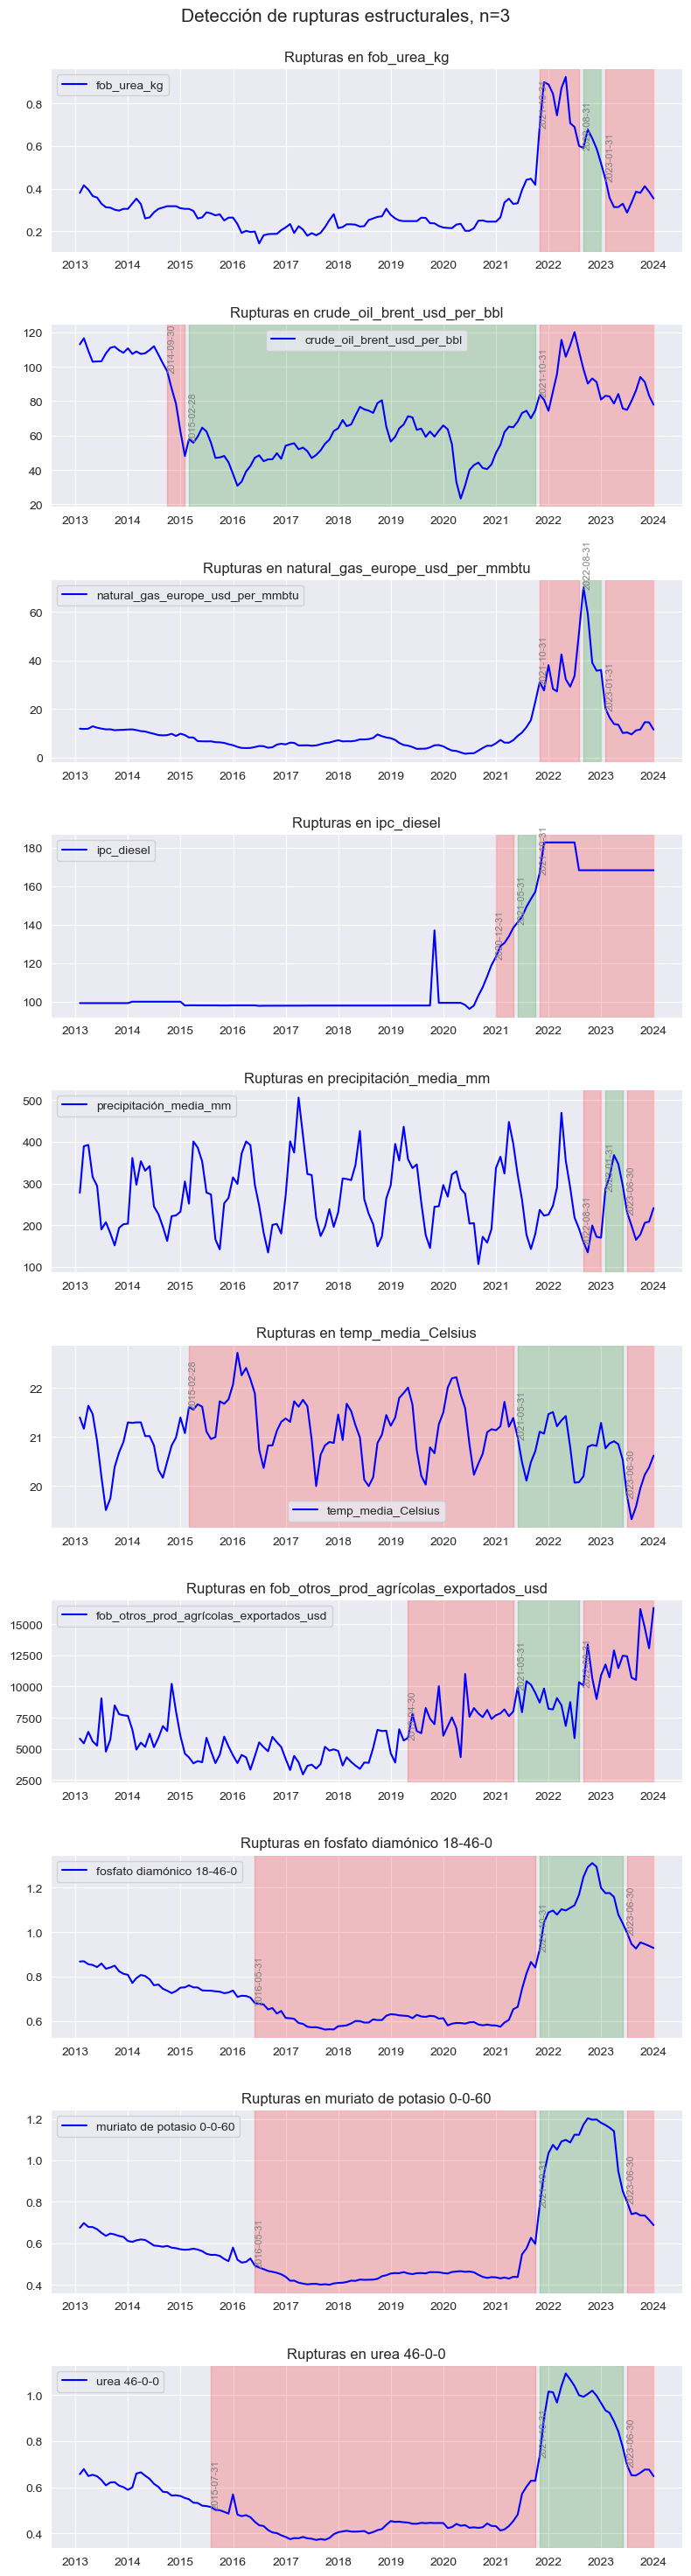

In [14]:
plot_change_points(df_no_estacionarias, n_bkps=3, annotate_breakpoints=True)

In [15]:
p_values = []

for break_date in X.index:
    result = test_known_structural_break(y, X, break_date)
    p_values.append(result['p-value'])

valores_p_cambio_estructural = pd.DataFrame(p_values, index=X.index, columns=['valor-p'])

c:\Users\ivan_\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:2285: RuntimeWarning: divide by zero encountered in scalar divide
  f_value = (ssr_restr - ssr_full) / df_diff / ssr_full * df_full


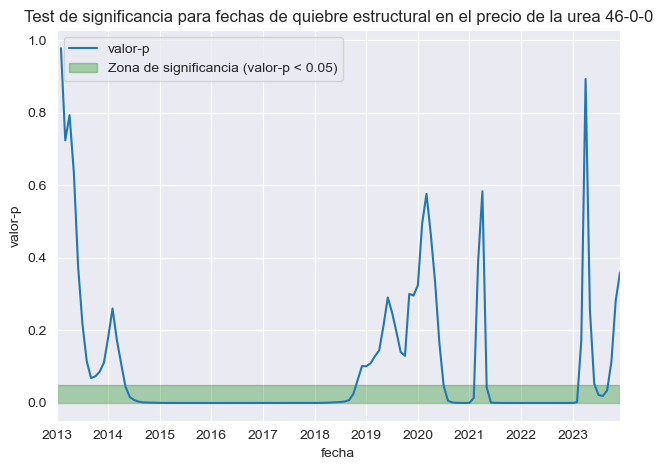

In [16]:
valores_p_cambio_estructural.plot()
plt.fill_between(X.index, 0.05, label="Zona de significancia (valor-p < 0.05)", color='green', alpha=0.3)
plt.title(f"Test de significancia para fechas de quiebre estructural en el precio de la {y.name}")
plt.ylabel("valor-p")
plt.xlabel("fecha")
plt.tight_layout()
plt.legend()
plt.show()

Entre 2016 y 2021, el precio de la urea en Ecuador experimentó cambios estructurales significativos, atribuibles a una combinación de eventos locales e internacionales que alteraron tanto la oferta como la demanda, tal como se evidencia en el gráfico.

En el ámbito local, el terremoto de Manabí y Esmeraldas en 2016 provocó interrupciones en la infraestructura logística y productiva del país, afectando la distribución de insumos clave como los fertilizantes. Este desastre no solo incrementó los costos logísticos asociados, sino que también desvió recursos económicos hacia la reconstrucción, alterando las dinámicas tradicionales del mercado.

A finales de 2019, la reducción de subsidios a combustibles y la inestabilidad social asociadas pudieron provocar un aumento en los costos logísticos internos, repercutiendo en el precio de la urea. Además, la incertidumbre económica pudo haber afectado las decisiones relacionadas con la importación y el almacenamiento de fertilizantes, incrementando la volatilidad en su precio durante este período.

En el plano internacional, la pandemia de COVID-19 en 2020-2021 generó una disrupción sin precedentes en las cadenas globales de suministro, impactando directamente la disponibilidad y los costos de los fertilizantes. En 2021, este efecto se amplificó debido al aumento sostenido en el precio del gas natural en Europa, el principal insumo para la producción de urea que Ecuador importa desde Rusia. Este incremento, motivado por tensiones geopolíticas y restricciones de suministro, desencadenó un alza significativa en los costos de producción y exportación de urea, lo que se reflejó en los mercados locales.

Estos eventos, tanto locales como internacionales, explican los quiebres estructurales observados en los análisis econométricos del período. La interacción entre factores internos, como desastres naturales e inestabilidad política, y shocks externos, como la crisis energética global, subraya la sensibilidad del mercado de fertilizantes a cambios en las condiciones económicas y geopolíticas. Este análisis evidencia la necesidad de monitorear continuamente las dinámicas globales y nacionales para anticipar y mitigar futuros impactos en el precio de la urea.

### Revisar homocedasticidad

In [17]:
# Recoger variables heterocedásticas en una lista:
variables_heterocedásticas = []

for col in df_na.columns:

    # Calcular estadísticos de heterocedasticidad:
    lm_stat, p_value = check_homoscedasticity(df_na[col])
    
    # # Imprimir estadísticos:
    # print(f"{col} ->  LM Statistic: {lm_stat}, p-value: {p_value}")
    
    # Filtrar variables con evidencia de heterocedasticidad:
    if p_value <= 0.05:
        variables_heterocedásticas.append(col)

# Crear un DataFrame de variables heterocedásticas:
df_heterocedásticas = df_na[variables_heterocedásticas].dropna()

df_heterocedásticas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 136 entries, 2013-01 to 2024-04
Data columns (total 8 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   fob_urea_kg                              136 non-null    float64
 1   crude_oil_brent_usd_per_bbl              136 non-null    float64
 2   natural_gas_europe_usd_per_mmbtu         136 non-null    float64
 3   ipc_diesel                               136 non-null    float64
 4   fob_otros_prod_agrícolas_exportados_usd  136 non-null    float64
 5   fosfato diamónico 18-46-0                136 non-null    float64
 6   muriato de potasio 0-0-60                136 non-null    float64
 7   urea 46-0-0                              136 non-null    float64
dtypes: float64(8)
memory usage: 9.6+ KB


In [18]:
df_ln_heterocedásticas = df_heterocedásticas.apply(np.log)

for col in df_ln_heterocedásticas.columns:

    # Calcular estadísticos de heterocedasticidad:
    lm_stat, p_value = check_homoscedasticity(df_ln_heterocedásticas[col])
    
    # Imprimir estadísticos:
    print(f"{col} ->  p-value: {p_value}")
    
    # Filtrar variables con evidencia de heterocedasticidad:

fob_urea_kg ->  p-value: 0.0
crude_oil_brent_usd_per_bbl ->  p-value: 0.92
natural_gas_europe_usd_per_mmbtu ->  p-value: 0.0
ipc_diesel ->  p-value: 0.0
fob_otros_prod_agrícolas_exportados_usd ->  p-value: 0.0
fosfato diamónico 18-46-0 ->  p-value: 0.581
muriato de potasio 0-0-60 ->  p-value: 0.048
urea 46-0-0 ->  p-value: 0.024


In [19]:
from scipy.stats import boxcox

df_heterocedásticas_boxcox = pd.DataFrame(index=df_heterocedásticas.index)

for col in df_heterocedásticas.columns:
    df_heterocedásticas_boxcox[col], lmbda = boxcox(df_heterocedásticas[col])

    # Calcular estadísticos de heterocedasticidad:
    lm_stat, p_value = check_homoscedasticity(df_heterocedásticas_boxcox[col])
    
    # Imprimir estadísticos:
    print(f"{col} ->  p-value: {p_value}")

fob_urea_kg ->  p-value: 0.001
crude_oil_brent_usd_per_bbl ->  p-value: 0.542
natural_gas_europe_usd_per_mmbtu ->  p-value: 0.001
ipc_diesel ->  p-value: 0.0
fob_otros_prod_agrícolas_exportados_usd ->  p-value: 0.0
fosfato diamónico 18-46-0 ->  p-value: 0.944
muriato de potasio 0-0-60 ->  p-value: 0.396
urea 46-0-0 ->  p-value: 0.145


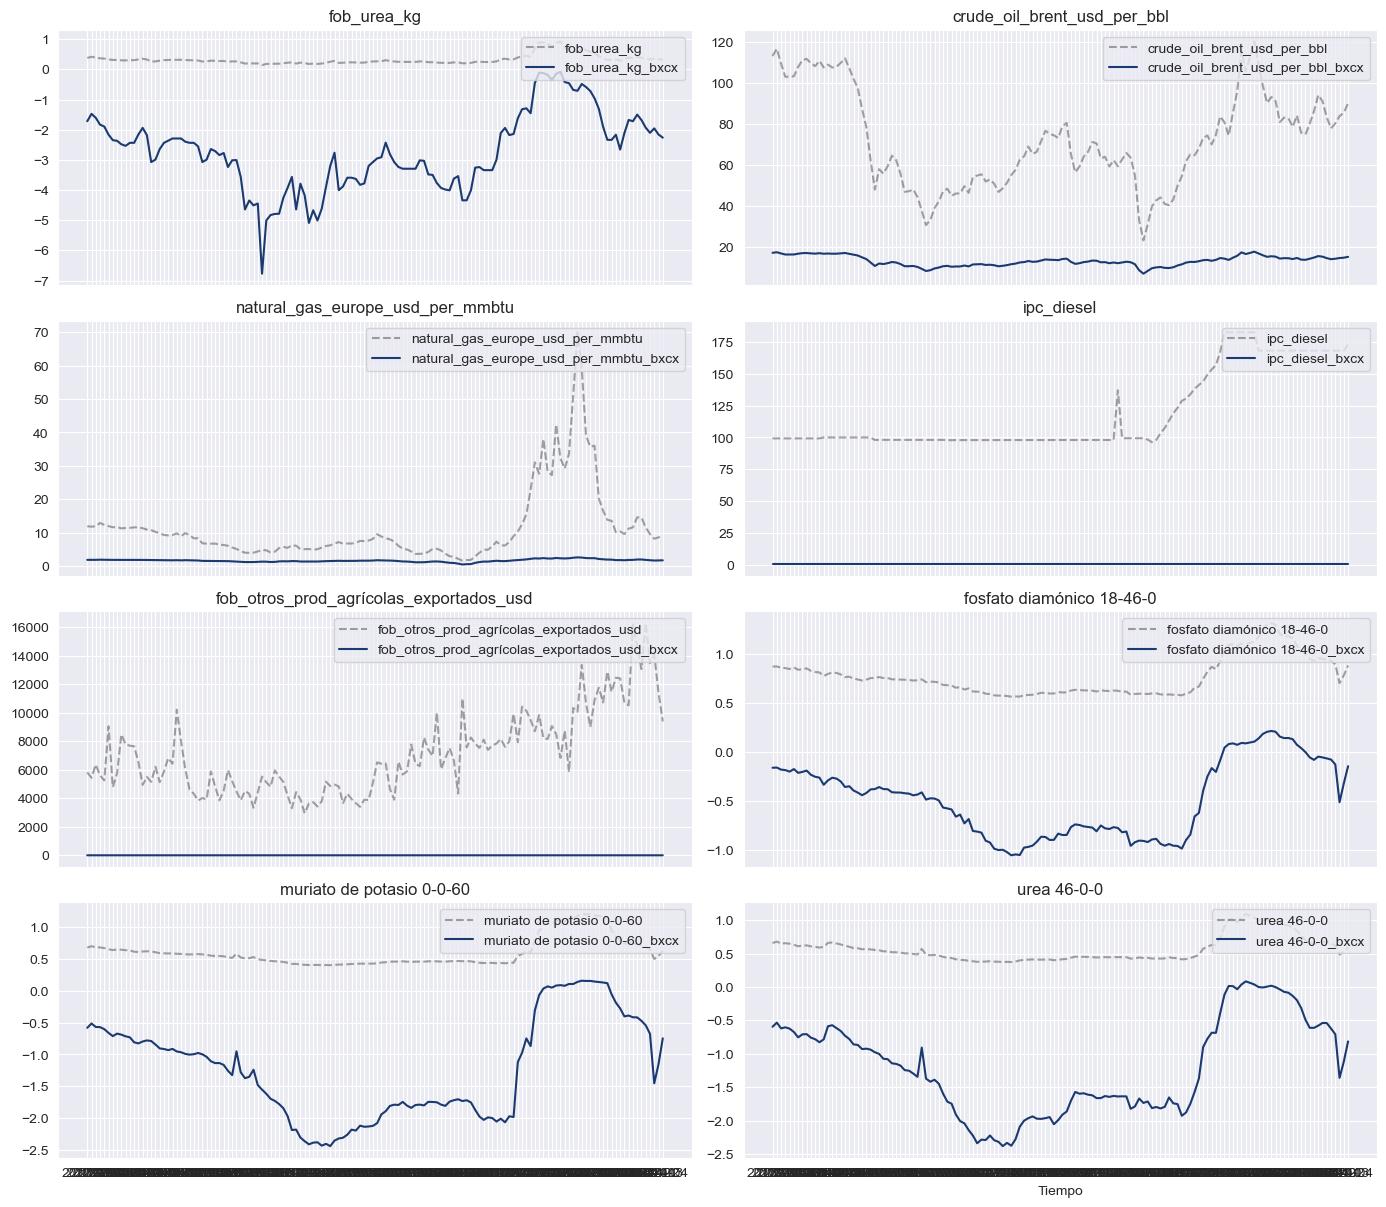

In [20]:
plot_comparison(df_heterocedásticas, df_heterocedásticas_boxcox, suffix='_bxcx')

### Diferenciación estacional

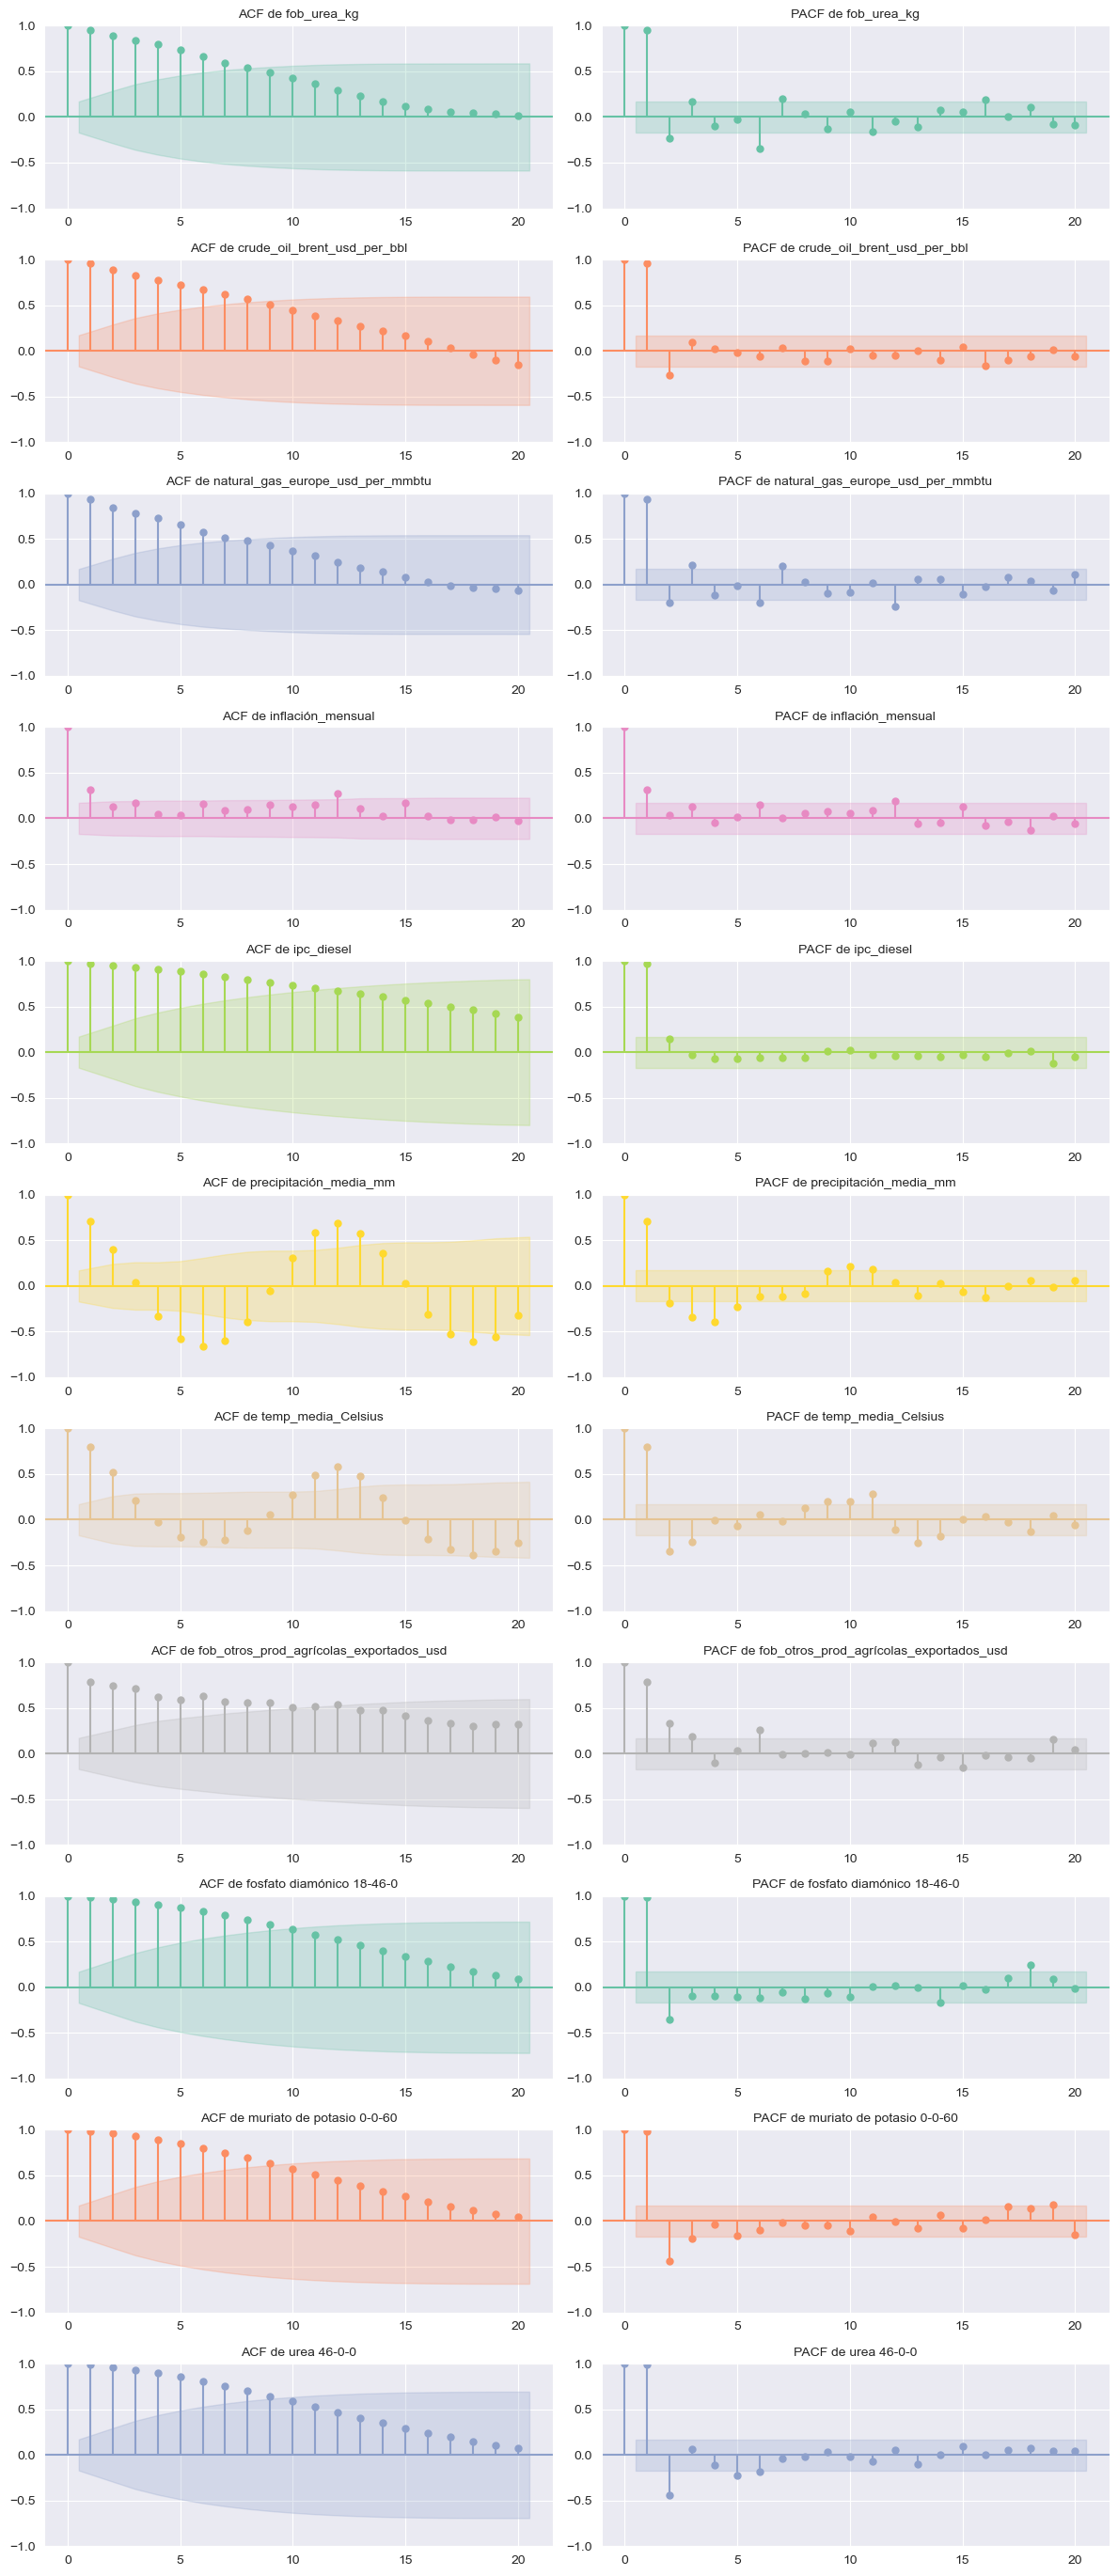

In [21]:
plot_acf_pacf(df.dropna(), lags=20, color_palette='Set2')

In [22]:
lista_var_estacionales = ['precipitación_media_mm', 'temp_media_Celsius']

var_estacionales = df[lista_var_estacionales].dropna()

var_estacionales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 146 entries, 2011-11-30 to 2023-12-31
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   precipitación_media_mm  146 non-null    float64
 1   temp_media_Celsius      146 non-null    float64
dtypes: float64(2)
memory usage: 3.4 KB


In [23]:
from statsmodels.tsa.stattools import adfuller

for col in var_estacionales.columns:
# Prueba ADF con términos estacionales
    adf_result = adfuller(var_estacionales[col], regression='ct')  # 'ct' incluye tendencia y constante
    print(col, ":")
    print("-> ADF Statistic:", round(adf_result[0], 3))
    print("-> p-value:", round(adf_result[1], 3))

precipitación_media_mm :
-> ADF Statistic: -2.494
-> p-value: 0.331
temp_media_Celsius :
-> ADF Statistic: -1.702
-> p-value: 0.75


Los resultados de la prueba ADF con tendencia y constante (regression='ct') en las series de precipitación media (mm) y temperatura media (°C) muestran valores p altos (0.239 y 0.782, respectivamente), lo que indica que no se puede rechazar la hipótesis nula de raíz unitaria. Esto sugiere que ambas series son no estacionarias, incluso al ajustar una tendencia lineal. 

Por otra parte, la estacionalidad inherente en estas variables podría requerir una diferenciación estacional adicional para estabilizar la serie y eliminar patrones cíclicos, permitiendo su análisis con modelos que asumen estacionariedad.

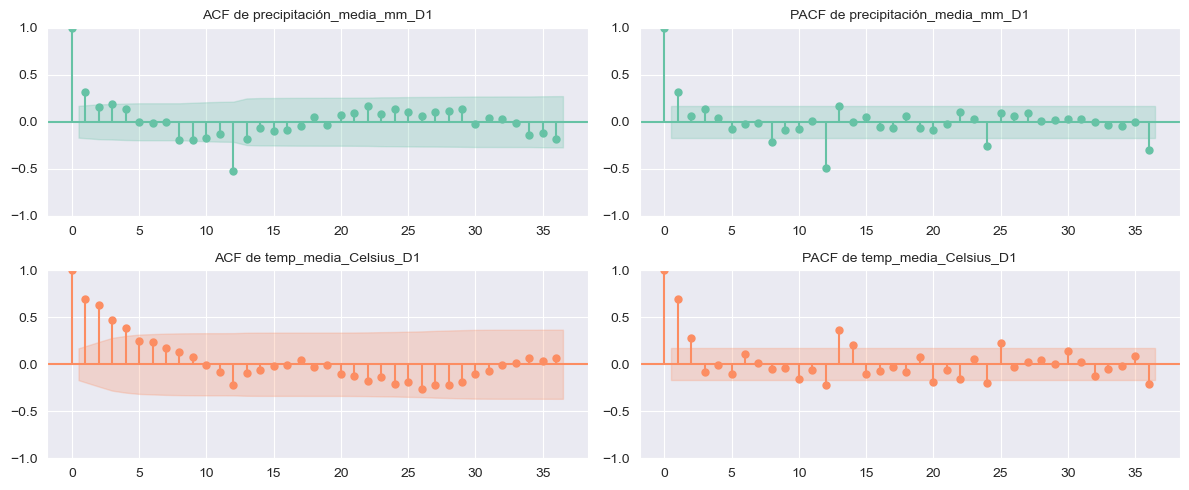

In [24]:
diff_estacional = var_estacionales.diff(12).add_suffix("_D1").dropna()

plot_acf_pacf(diff_estacional, lags=36, color_palette='Set2')

Un pico significativo en el lag estacional (12) del ACF en  es un patrón común y esperado en series originalmente estacionales y no requiere más transformaciones si la serie es estacionaria tras la diferenciación. Notamos este patrón en el ACF de `precipitación_media_mm_D1` mas no en `temp_media_Celsius_D1`.

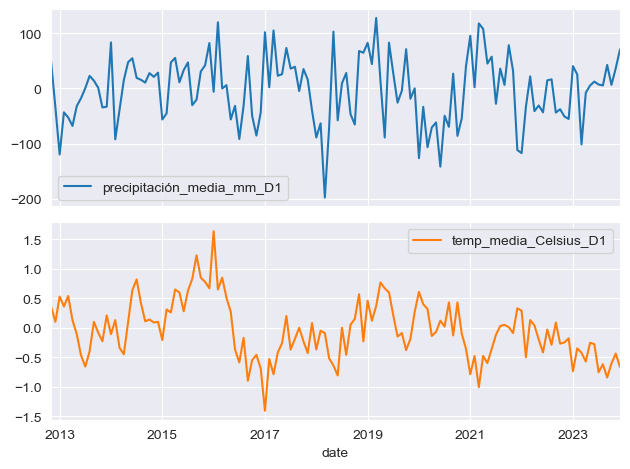

In [25]:
diff_estacional.plot(subplots=True)
plt.tight_layout()
plt.show()

En los gráficos de línea de las series con diferenciación estacional D=1 (12 períodos), notamos que la varianza de `precipitación_media_mm_D1`; no así la varianza de `temp_media_Celsius_D1`.

Estacionareidad evaluada por *Augmented Dickey-Fuller* (ADF) y *Kwiatkowski-Phillips-Schmidt-Shin* (KPSS):

In [26]:
diff_estacional = diff_estacional.dropna()

evaluar_estacionareidad_series_estacionales = evaluar_estacionareidad(diff_estacional)

evaluar_estacionareidad_series_estacionales

,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,precipitación_media_mm_D1,0.000092,0.100000,True,False,Estacionario
1,temp_media_Celsius_D1,0.517717,0.077895,False,False,No claro


**Conclusión:** La diferenciación estacional `D=1` convirtió la variable `precipitación_media_mm` en estacionaria exitosamente, pero `temp_media_Celsius_D1` requiere modelado adicional.

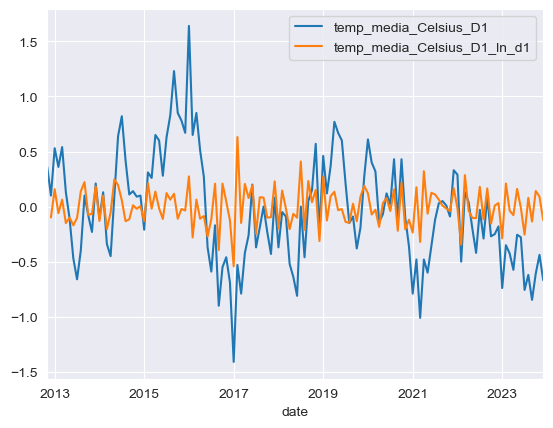

In [27]:
# Aplicar transformaciones para que 'temp_media_Celsius_D1' alcance estacionareidad:
diff_estacional['temp_media_Celsius_D1_ln_d1'] = diff_estacional['temp_media_Celsius_D1']\
    .add(-diff_estacional['temp_media_Celsius_D1'].min() + 1)\
    .apply(np.log)\
    .diff()

# Comparación visual entre 
diff_estacional['temp_media_Celsius_D1'].plot()
diff_estacional['temp_media_Celsius_D1_ln_d1'].plot()
plt.legend()
plt.show()

In [28]:
diff_estacional = diff_estacional.dropna()

evaluar_estacionareidad_series_estacionales = evaluar_estacionareidad(diff_estacional)

evaluar_estacionareidad_series_estacionales

,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,precipitación_media_mm_D1,0.000076,0.100000,True,False,Estacionario
1,temp_media_Celsius_D1,0.518581,0.082785,False,False,No claro
2,temp_media_Celsius_D1_ln_d1,0.000002,0.100000,True,False,Estacionario


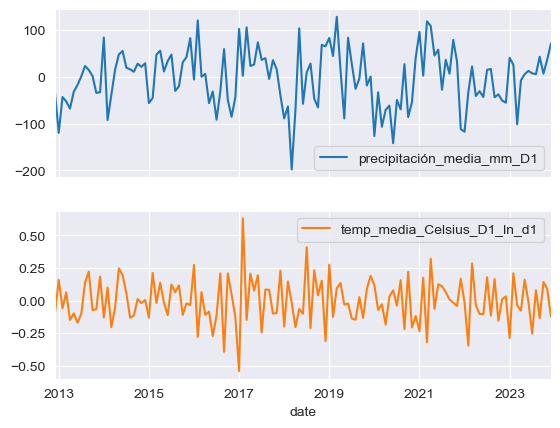

In [29]:
var_estacionales_estacionarias = diff_estacional.drop(columns=['temp_media_Celsius_D1'])

var_estacionales_estacionarias.plot(subplots=True)
plt.show()

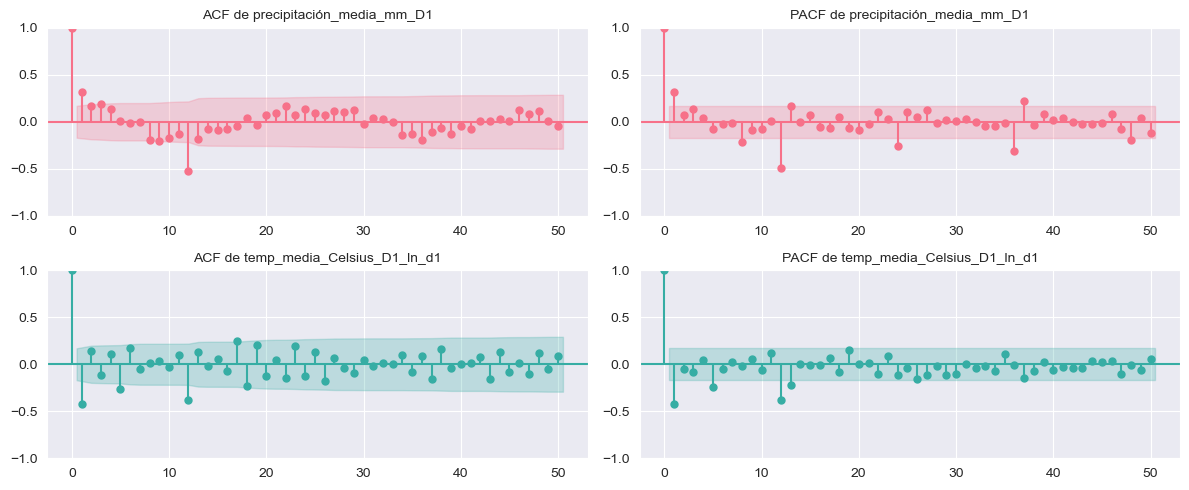

In [30]:
plot_acf_pacf(var_estacionales_estacionarias.dropna(), lags=50)

In [31]:
var_estacionales_estacionarias.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 133 entries, 2012-12-31 to 2023-12-31
Data columns (total 2 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   precipitación_media_mm_D1    133 non-null    float64
 1   temp_media_Celsius_D1_ln_d1  133 non-null    float64
dtypes: float64(2)
memory usage: 3.1 KB


### Variables no estacionales

In [32]:
y = 'urea 46-0-0'

# Eliminar valores nulos para análisis de estacionareidad:
var_no_estacionales = df.drop(columns=lista_var_estacionales)['2012-11-30':'2024-03-31'].dropna()

var_no_estacionales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 135 entries, 2013-01-31 to 2024-03-31
Data columns (total 9 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   fob_urea_kg                              135 non-null    float64
 1   crude_oil_brent_usd_per_bbl              135 non-null    float64
 2   natural_gas_europe_usd_per_mmbtu         135 non-null    float64
 3   inflación_mensual                        135 non-null    float64
 4   ipc_diesel                               135 non-null    float64
 5   fob_otros_prod_agrícolas_exportados_usd  135 non-null    float64
 6   fosfato diamónico 18-46-0                135 non-null    float64
 7   muriato de potasio 0-0-60                135 non-null    float64
 8   urea 46-0-0                              135 non-null    float64
dtypes: float64(9)
memory usage: 10.5 KB


In [33]:
# Extraer valores de meses para creación de índices tras diferenciación:
mes_2 = var_no_estacionales.index.min() + pd.DateOffset(months=1)
mes_2 = mes_2.strftime('%Y-%m')

mes_3 = var_no_estacionales.index.min() + pd.DateOffset(months=2)
mes_3 = mes_3.strftime('%Y-%m')

mes_4 = var_no_estacionales.index.min() + pd.DateOffset(months=3)
mes_4 = mes_4.strftime('%Y-%m')

último_mes = var_no_estacionales.index.max() + pd.DateOffset(months=1)
último_mes = último_mes.strftime('%Y-%m')

In [34]:
# Evaluar estadísticos ADF y KPSS de estacionareidad sobre datos originales:
df_test_estacionareidad = evaluar_estacionareidad(var_no_estacionales)

df_test_estacionareidad

,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,fob_urea_kg,2.193963e-01,0.023028,False,True,No estacionario
1,crude_oil_brent_usd_per_bbl,1.134769e-01,0.100000,False,False,No claro
2,natural_gas_europe_usd_per_mmbtu,2.682730e-01,0.038309,False,True,No estacionario
3,inflación_mensual,3.809845e-13,0.085182,True,False,Estacionario
4,ipc_diesel,9.595216e-01,0.010000,False,True,No estacionario
5,fob_otros_prod_agrícolas_exportados_usd,9.985632e-01,0.010000,False,True,No estacionario
6,fosfato diamónico 18-46-0,1.518363e-01,0.023557,False,True,No estacionario
7,muriato de potasio 0-0-60,3.831017e-01,0.022372,False,True,No estacionario
8,urea 46-0-0,1.463115e-01,0.026651,False,True,No estacionario


#### Diferenciación d=1:

In [35]:
q_inferior = 0
q_superior = 1

In [36]:
import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs

# Extraer nombres de variables que no son originalmente estacionarias:
variables_no_estacionarias = df_test_estacionareidad[df_test_estacionareidad['estado_estacionario'] != 'Estacionario']['variable'].values

# Crear un df de variables no estacionarias:
df_no_estacionarias = var_no_estacionales[variables_no_estacionarias]


In [38]:
# Diferenciar para d=1 y agregar sufijo:
df_no_estacionarias_diferenciadas_d1 = df_no_estacionarias\
    .apply(np.diff, n=1)\
    .add_suffix("_d1")

# Establecer índice, tomando en cuenta que la diferenciación elimina la primera fila:
df_no_estacionarias_diferenciadas_d1.index = pd.date_range(start=mes_2, end=último_mes, freq='M')

# Recortar valores extremos bajo criterio de cuantiles:
df_no_estacionarias_diferenciadas_d1_tmd = df_no_estacionarias_diferenciadas_d1\
    .apply(lambda x: x.clip(lower=x.quantile(q_inferior), upper=x.quantile(q_superior)))

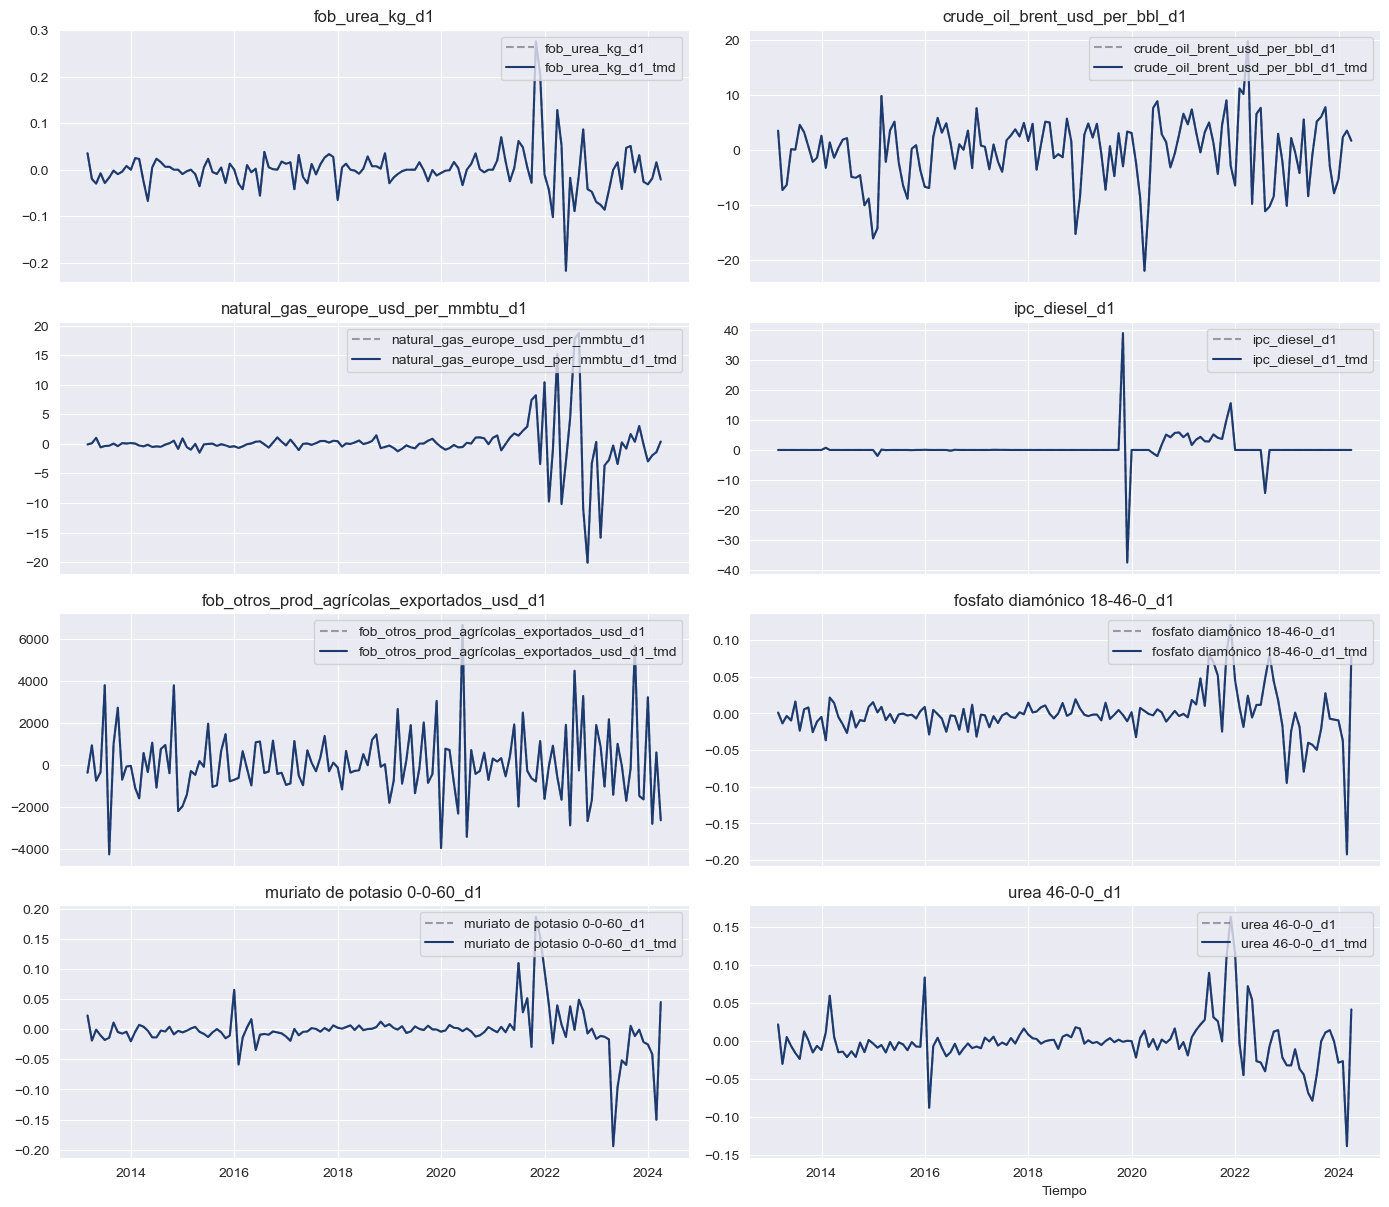

In [39]:
# Visualizar diferencias en datos tras recortes de valores extremos:
plot_comparison(df_no_estacionarias_diferenciadas_d1, df_no_estacionarias_diferenciadas_d1_tmd, suffix='_tmd')

In [40]:
# Evaluar estadísticos ADF y KPSS de estacionareidad tras diferenciación d=1 y recorte:
df_test_estacionareidad_d1 = evaluar_estacionareidad(df_no_estacionarias_diferenciadas_d1_tmd)

df_test_estacionareidad_d1

,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,fob_urea_kg_d1,5.245918e-04,0.1,True,False,Estacionario
1,crude_oil_brent_usd_per_bbl_d1,1.056183e-11,0.1,True,False,Estacionario
2,natural_gas_europe_usd_per_mmbtu_d1,1.061201e-05,0.1,True,False,Estacionario
3,ipc_diesel_d1,3.394431e-28,0.1,True,False,Estacionario
4,fob_otros_prod_agrícolas_exportados_usd_d1,7.542547e-02,0.1,False,False,No claro
5,fosfato diamónico 18-46-0_d1,1.819057e-13,0.1,True,False,Estacionario
6,muriato de potasio 0-0-60_d1,1.998132e-05,0.1,True,False,Estacionario
7,urea 46-0-0_d1,5.160035e-02,0.1,False,False,No claro


In [41]:
# Extraer nombres de variables que no son estacionarias después de d=1 pero antes del recorte:
variables_no_estacionarias_tras_d1 = df_test_estacionareidad_d1[df_test_estacionareidad_d1['estado_estacionario'] != 'Estacionario']['variable'].values

# Obtener un DataFrame que solo contiene las variables estacionarias tras d=1 y eliminación de atípicos: 
df_variables_estacionarias_d1_tmd = df_no_estacionarias_diferenciadas_d1_tmd\
    .drop(columns=variables_no_estacionarias_tras_d1)\
    # .add_suffix('_tmd')

df_variables_estacionarias_d1_tmd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134 entries, 2013-02-28 to 2024-03-31
Freq: M
Data columns (total 6 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   fob_urea_kg_d1                       134 non-null    float64
 1   crude_oil_brent_usd_per_bbl_d1       134 non-null    float64
 2   natural_gas_europe_usd_per_mmbtu_d1  134 non-null    float64
 3   ipc_diesel_d1                        134 non-null    float64
 4   fosfato diamónico 18-46-0_d1         134 non-null    float64
 5   muriato de potasio 0-0-60_d1         134 non-null    float64
dtypes: float64(6)
memory usage: 7.3 KB


#### Diferenciación d=2:

In [43]:
# Crear un df de variables no estacionarias tras d=1 pero antes del recorte de extremos:
df_no_estacionarias_d1 = df_no_estacionarias_diferenciadas_d1[variables_no_estacionarias_tras_d1]

# Segunda diferenciación de variables no estacionarias tras d=1:
df_no_estacionarias_diferenciadas_d2 = df_no_estacionarias_d1.apply(np.diff, n=1)

# Cambiar el nombre de columnas para identificar 'd=2':
df_no_estacionarias_diferenciadas_d2.columns = [col.replace("_d1", "_d2") for col in df_no_estacionarias_diferenciadas_d2.columns]

# Establecer índice, tomando en cuenta que la diferenciación elimina la primera fila:
df_no_estacionarias_diferenciadas_d2.index = pd.date_range(start=mes_3, end=último_mes, freq='M')

# Recortar valores extremos bajo criterio de cuantiles:
df_no_estacionarias_diferenciadas_d2_tmd = df_no_estacionarias_diferenciadas_d2\
    .apply(lambda x: x.clip(lower=x.quantile(q_inferior), upper=x.quantile(q_superior)))

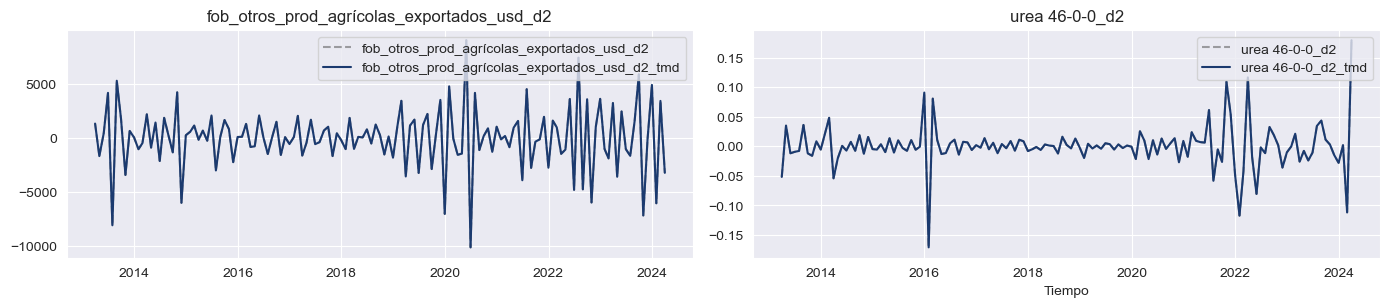

In [44]:
# Visualizar diferencias en datos tras recortes de valores extremos:
plot_comparison(df_no_estacionarias_diferenciadas_d2, df_no_estacionarias_diferenciadas_d2_tmd, suffix='_tmd')

In [45]:
# Evaluar estadísticos ADF y KPSS de estacionareidad:
df_test_estacionareidad_d2 = evaluar_estacionareidad(df_no_estacionarias_diferenciadas_d2_tmd)

df_test_estacionareidad_d2

,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,fob_otros_prod_agrícolas_exportados_usd_d2,6.844011e-14,0.1,True,False,Estacionario
1,urea 46-0-0_d2,1.378120e-18,0.1,True,False,Estacionario


In [46]:
# Extraer nombres de variables que no son estacionarias después de d=2 pero antes del recorte:
variables_no_estacionarias_tras_d2 = df_test_estacionareidad_d2[df_test_estacionareidad_d2['estado_estacionario'] != 'Estacionario']['variable'].values

# Obtener un DataFrame que solo contiene las variables estacionarias tras d=1 y eliminación de atípicos: 
df_variables_estacionarias_d2_tmd = df_no_estacionarias_diferenciadas_d2_tmd\
    .drop(columns=variables_no_estacionarias_tras_d2)\
    # .add_suffix('_tmd')

df_variables_estacionarias_d2_tmd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 133 entries, 2013-03-31 to 2024-03-31
Freq: M
Data columns (total 2 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   fob_otros_prod_agrícolas_exportados_usd_d2  133 non-null    float64
 1   urea 46-0-0_d2                              133 non-null    float64
dtypes: float64(2)
memory usage: 3.1 KB


#### Diferenciación d=3:

In [47]:
# # Crear un df de variables no estacionarias tras d=2 pero antes del recorte de extremos:
# df_no_estacionarias_d2 = df_no_estacionarias_diferenciadas_d2[variables_no_estacionarias_tras_d2]

# # Tercera diferenciación de variables no estacionarias tras d=2:
# df_no_estacionarias_diferenciadas_d3 = df_no_estacionarias_d2.apply(np.diff, n=1)

# # Cambiar el nombre de columnas para identificar 'd=3':
# df_no_estacionarias_diferenciadas_d3.columns = [col.replace("_d2", "_d3") for col in df_no_estacionarias_diferenciadas_d3.columns]

# # Establecer índice, tomando en cuenta que la diferenciación elimina la primera fila:
# df_no_estacionarias_diferenciadas_d3.index = pd.date_range(start=mes_4, end=último_mes, freq='ME')

# # Recortar valores extremos bajo criterio de cuantiles:
# df_no_estacionarias_diferenciadas_d3_tmd = df_no_estacionarias_diferenciadas_d3\
#     .apply(lambda x: x.clip(lower=x.quantile(q_inferior), upper=x.quantile(q_superior)))


In [48]:
# # Visualizar diferencias en datos tras recortes de valores extremos:
# plot_comparison(df_no_estacionarias_diferenciadas_d3, df_no_estacionarias_diferenciadas_d3_tmd, suffix='_tmd')

In [49]:
# # Evaluar estadísticos ADF y KPSS de estacionareidad:
# df_test_estacionareidad_d3 = evaluar_estacionareidad(df_no_estacionarias_diferenciadas_d3_tmd)

# df_test_estacionareidad_d3

In [50]:
# # Extraer nombres de variables que no son estacionarias después de d=3 pero antes del recorte:
# variables_no_estacionarias_tras_d3 = df_test_estacionareidad_d3[df_test_estacionareidad_d3['estado_estacionario'] != 'Estacionario']['variable'].values

# # Obtener un DataFrame que solo contiene las variables estacionarias tras d=3 y eliminación de atípicos: 
# df_variables_estacionarias_d3_tmd = df_no_estacionarias_diferenciadas_d3_tmd\
#     .drop(columns=variables_no_estacionarias_tras_d3)\
#     .add_suffix('_tmd')

# df_variables_estacionarias_d3_tmd.info()

### Cohesión de variables estacionarias y con valores extremos recortados:

In [51]:
# Extraer las variables originalmente estacionarias:
variables_originalmente_estacionarias = df_test_estacionareidad[df_test_estacionareidad['estado_estacionario'] == 'Estacionario']['variable'].values

df_originalmente_estacionarias = var_no_estacionales[variables_originalmente_estacionarias]

df_estacionarios = pd.concat(
    [df_originalmente_estacionarias, var_estacionales_estacionarias, df_variables_estacionarias_d1_tmd, df_variables_estacionarias_d2_tmd], # df_variables_estacionarias_d3_tmd], 
    axis=1, 
    join='outer'
    )\
        ['2013':'2023']

df_estacionarios = df_estacionarios.fillna(df_estacionarios.median())\

df_estacionarios.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 2013-01-31 to 2023-12-31
Freq: M
Data columns (total 11 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   inflación_mensual                           132 non-null    float64
 1   precipitación_media_mm_D1                   132 non-null    float64
 2   temp_media_Celsius_D1_ln_d1                 132 non-null    float64
 3   fob_urea_kg_d1                              132 non-null    float64
 4   crude_oil_brent_usd_per_bbl_d1              132 non-null    float64
 5   natural_gas_europe_usd_per_mmbtu_d1         132 non-null    float64
 6   ipc_diesel_d1                               132 non-null    float64
 7   fosfato diamónico 18-46-0_d1                132 non-null    float64
 8   muriato de potasio 0-0-60_d1                132 non-null    float64
 9   fob_otros_prod_agrícolas_exportados_usd_d2  132 non-null    

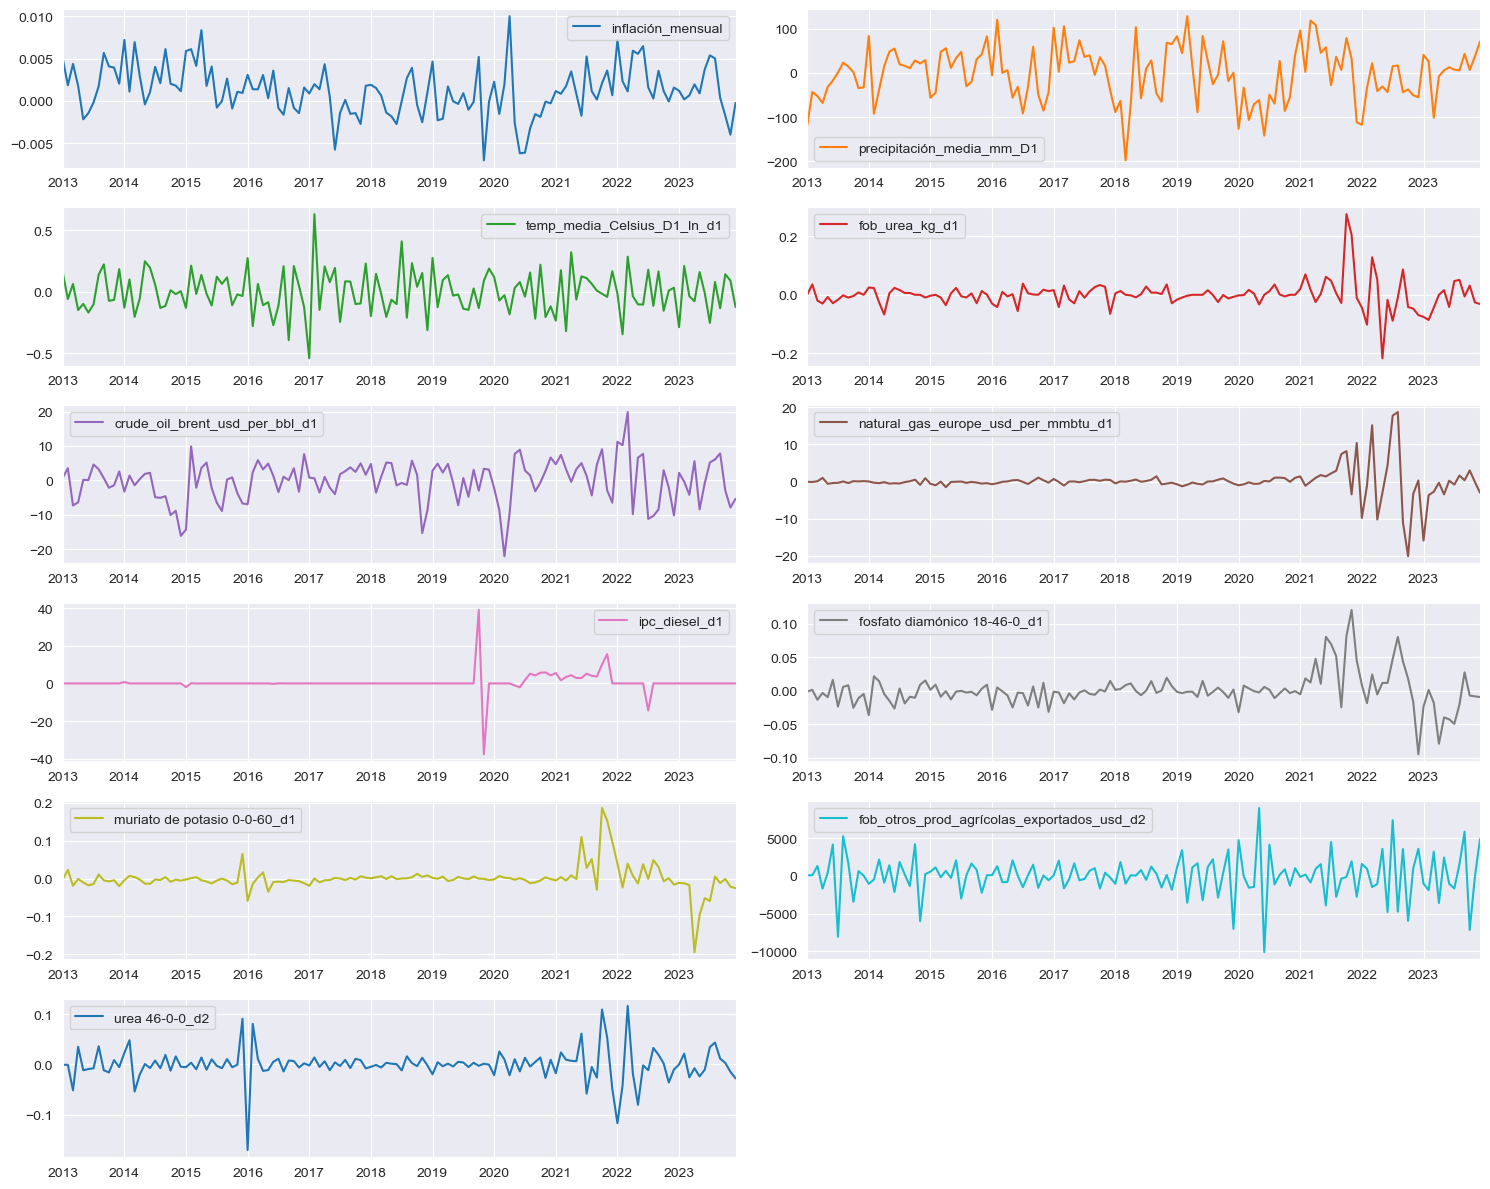

In [52]:
num_de_filas = ((df_estacionarios.shape[1] + 1) // 2)

df_estacionarios.plot(
    subplots=True,
    layout=(num_de_filas, 2),
    figsize=(15, 2 * num_de_filas),
    sharex=False
    )

plt.tight_layout()
plt.show()

In [53]:
# df_estacionarios.to_csv('data/df_estacionarios.csv')

In [54]:
# Evaluar estadísticos ADF y KPSS de estacionareidad:
verificar_estacionareidad = evaluar_estacionareidad(df_estacionarios)

verificar_estacionareidad

,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,inflación_mensual,7.021729e-13,0.079594,True,False,Estacionario
1,precipitación_media_mm_D1,1.389231e-04,0.100000,True,False,Estacionario
2,temp_media_Celsius_D1_ln_d1,1.921345e-06,0.100000,True,False,Estacionario
3,fob_urea_kg_d1,5.776155e-04,0.100000,True,False,Estacionario
4,crude_oil_brent_usd_per_bbl_d1,2.690117e-13,0.100000,True,False,Estacionario
5,natural_gas_europe_usd_per_mmbtu_d1,1.324380e-05,0.100000,True,False,Estacionario
6,ipc_diesel_d1,4.765658e-28,0.100000,True,False,Estacionario
7,fosfato diamónico 18-46-0_d1,1.234462e-02,0.100000,True,False,Estacionario
8,muriato de potasio 0-0-60_d1,3.517005e-05,0.100000,True,False,Estacionario
9,fob_otros_prod_agrícolas_exportados_usd_d2,2.050004e-14,0.100000,True,False,Estacionario


In [55]:
# Extraer variables predictoras:
X = df_estacionarios.drop(columns=['fosfato diamónico 18-46-0_d1', 'muriato de potasio 0-0-60_d1', 'urea 46-0-0_d2'])

# Extraer variable objetivo:
target_var = 'urea 46-0-0_d2'

y = df_estacionarios[target_var]

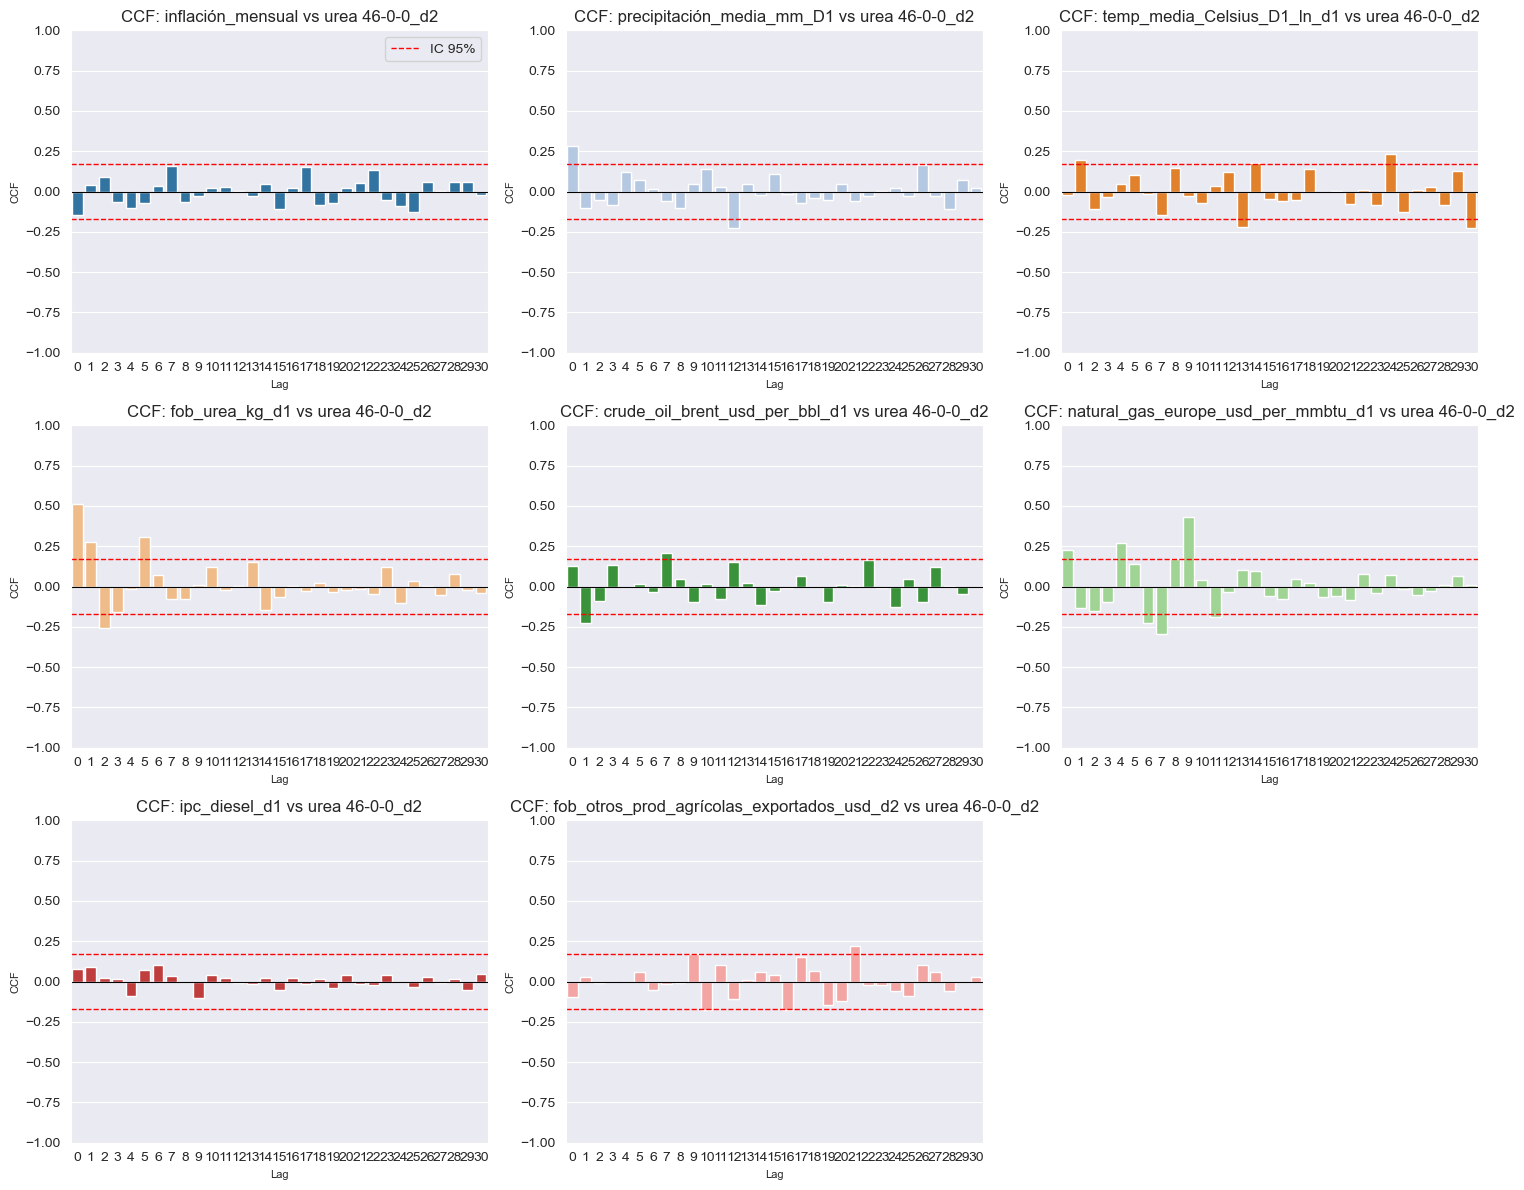

In [56]:
plot_ccf_subplots(df_estacionarios, X.columns.tolist(), target_var, max_lag=30, palette_name="tab20")

### Regresión de variables no estacionarias

In [57]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Crear un DataFrame para almacenar los VIFs
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data.sort_values(by='VIF', ascending=False)

,Variable,VIF
6,ipc_diesel_d1,1.186207
3,fob_urea_kg_d1,1.138433
0,inflación_mensual,1.096321
5,natural_gas_europe_usd_per_mmbtu_d1,1.058873
2,temp_media_Celsius_D1_ln_d1,1.057095
1,precipitación_media_mm_D1,1.053676
7,fob_otros_prod_agrícolas_exportados_usd_d2,1.027168
4,crude_oil_brent_usd_per_bbl_d1,1.010180


c:\Users\ivan_\anaconda3\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


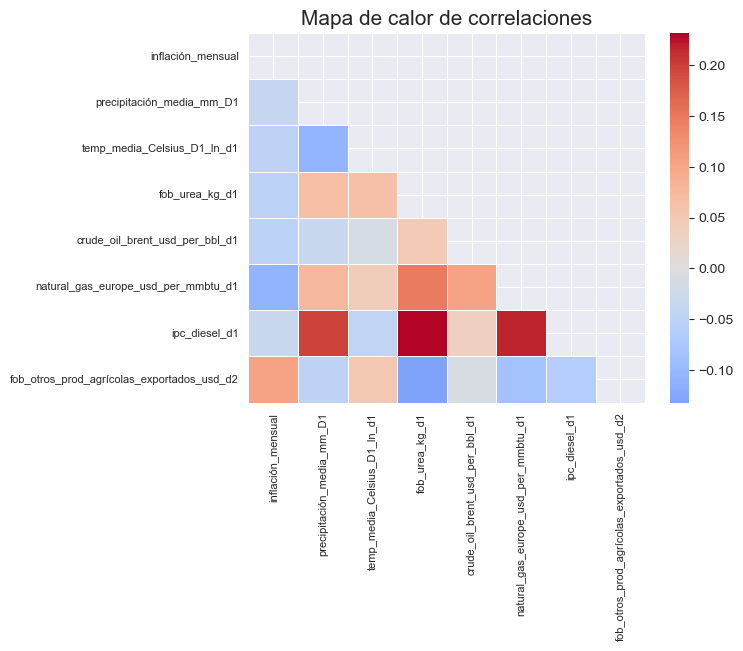

In [58]:
# Graficar mapa de calor de correlaciones no lineales:
corr = X.corr(method="spearman")
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(data=corr, mask=mask, cmap='coolwarm', center=0, linewidths=0.5, annot=True, annot_kws={"size": 5})
plt.title('Mapa de calor de correlaciones', size=15)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [59]:
import statsmodels.api as sm

X = sm.add_constant(X)  # Agrega una constante para el intercepto
modelo_robusto = sm.OLS(y, X).fit(cov_type='HC0')  # Modelo robusto a heterocedasticidad
print(modelo_robusto.summary())

                            OLS Regression Results                            
Dep. Variable:         urea 46-0-0_d2   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     12.19
Date:               do., 24 nov. 2024   Prob (F-statistic):           1.01e-12
Time:                        20:04:32   Log-Likelihood:                 295.81
No. Observations:                 132   AIC:                            -573.6
Df Residuals:                     123   BIC:                            -547.7
Df Model:                           8                                         
Covariance Type:                  HC0                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

### Incremento del precio del gas natural en 2021 y su impacto en los costos de producción

En 2021, el precio del gas natural aumentó significativamente, marcando un posible cambio estructural en su dinámica de mercado. Este incremento estuvo impulsado por factores como la recuperación económica post-pandemia, inviernos más fríos y veranos más calurosos en Europa, una alta demanda de gas natural licuado (GNL) en Asia, y tensiones geopolíticas relacionadas con el suministro ruso. Además, la transición energética hacia fuentes renovables limitó las inversiones en gas fósil, restringiendo la capacidad de respuesta de la oferta ante el alza de la demanda.

El gas natural, como insumo principal en la producción de urea, sufrió un encarecimiento que afectó los costos de producción. Este impacto se trasladó al precio FOB (Free on Board) de la urea en mercados como Asia y al precio CIF (Cost, Insurance, and Freight) en países importadores como Ecuador. Dado que Ecuador importa principalmente urea desde Rusia, los precios reflejaron el aumento de los costos energéticos europeos.

El análisis de las series de tiempo de precios sugiere un posible cambio estructural a partir de 2021. Este cambio se caracteriza por un aumento persistente de precios, mayor volatilidad, y alteraciones en las correlaciones entre variables clave, como el gas natural y la urea. Los modelos tradicionales de series de tiempo pueden no ser suficientes para capturar estas nuevas dinámicas, lo que resalta la necesidad de segmentar temporalmente las series y considerar variables exógenas, como tensiones geopolíticas y costos energéticos.